In [1]:
from pybullet_suite import *
from kinjax import *
from jax import jit, vmap
import jax.numpy as jnp
import open3d as o3d

pybullet build time: May 20 2022 19:44:17


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
urdf = "panda.urdf"
ee_link_name = "panda_grasptarget"
world = BulletWorld(gui=False)
panda = world.load_robot(Panda, "panda")
lb, ub = panda.joint_lower_limit, panda.joint_upper_limit
dof = 7
link_dict, joint_dict = get_link_joint_dict(urdf)
fk = get_FK_fn(link_dict, joint_dict, dof, ee_link_name)
fk_batch = get_FK_fn(link_dict, joint_dict, dof, ee_link_name, batch=True)
jac = get_jacobian_fn(link_dict, joint_dict, dof, ee_link_name)
jac_batch = get_jacobian_fn(link_dict, joint_dict, dof, ee_link_name, batch=True)

argv[0]=
Robot name: panda


In [3]:
# from jax import lax
# def mat2rpy(R):
#     def singular_case(R, sy): #cos(p) = 0
#         r = jnp.arctan2(-R[1,2], R[1,1])
#         p = jnp.arctan2(-R[2,0], sy)
#         y = 0.
#         return jnp.array([r, p, y])
#     def normal_case(R, sy):
#         r = jnp.arctan2(R[2,1] , R[2,2])
#         p = jnp.arctan2(-R[2,0], sy)
#         y = jnp.arctan2(R[1,0], R[0,0])
#         return jnp.array([r, p, y])
#     sy = jnp.sqrt(R[2,1]**2 + R[2,2]**2)
#     return lax.cond(sy < 1e-6, singular_case, normal_case, R, sy)
    
# def to_pose_vec(pose_mat):
#     return jnp.hstack([pose_mat[:3, -1], mat2rpy(pose_mat[:3, :3])])
    
# def get_grid_index(pose_mat):
#     pose_vec = to_pose_vec(pose_mat)
#     grid_index = (pose_vec - grid_min) // grid_size
#     return grid_index.astype(int)

# get_grid_index_batch = jit(vmap(get_grid_index))

# def get_manipulability_batch(joints):
#     poses = fk_batch(joints)
#     jacs = jac_batch(joints)
#     manips = jnp.sqrt(jnp.linalg.det(jnp.einsum("ijk,ilk->ijl", jacs, jacs)))
#     indexes = get_grid_index_batch(poses)
#     return indexes, manips
# get_manipulability_batch = jit(get_manipulability_batch)

In [4]:
def get_manip(joint):
    #pose = fk(joint)
    j = jac(joint)
    manip = 1/jnp.linalg.cond(j@j.T)
    joint_limit_potential = 1/len(joint)/4*jnp.sum((ub-lb)**2/(ub-joint)/(joint-lb))
    joint_limit_penalty = jnp.exp(1-joint_limit_potential/3)
    return manip*joint_limit_penalty
get_manip_batch = jax.vmap(get_manip)

In [5]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def generate_uniform_points_on_sphere(num_points):
    indices = np.arange(0, num_points, dtype=float) + 0.5
    phi = np.arccos(1 - 2 * indices / num_points)
    theta = np.pi * (1 + 5**0.5) * indices

    points = np.zeros((num_points, 3))
    points[:, 0] = np.cos(theta) * np.sin(phi)
    points[:, 1] = np.sin(theta) * np.sin(phi)
    points[:, 2] = np.cos(phi)
    return points

In [6]:
n = 1000
def generate_SO3_grid(n):
    phi = np.sqrt(2)
    psi = 1.533751168755204288118041 
    qtns = []
    for i in range(n):
        s = i + 1/2
        t = s/n
        d = np.pi * 2 * s
        r = np.sqrt(t)
        R = np.sqrt(1-t)
        alpha, beta = d/phi, d/psi
        qtn = np.array([r*np.sin(alpha), r*np.cos(alpha), R*np.sin(beta), R*np.cos(beta)])
        qtns.append(qtn)
    return qtns

In [7]:
qtn_grids = jnp.array(generate_SO3_grid(1000))
# roll_grid = np.linspace(-np.pi, np.pi, 12)
# pitch_grid = np.linspace(-np.pi/2, np.pi/2, 6)
# yaw_grid = np.linspace(-np.pi, np.pi, 12)

In [8]:
unit_sphere = generate_uniform_points_on_sphere(1600)
hemisphere = unit_sphere[unit_sphere[:,2] > 0]
xyz_grids = []
for r in np.linspace(0, 1, 21)[1:]:
    xyz_grids.append(hemisphere * r)
xyz_grids = jnp.vstack(xyz_grids)

In [9]:
joint = panda.get_random_config()
T = fk(joint)
xyz = T[:3, -1]

In [10]:
from jax import lax
def rotmat_to_qtn(R):
    tr = jnp.trace(R)
    def normal(R, tr):
        s = jnp.sqrt(tr+1.)*2
        w = 0.25*s
        x = (R[2,1] - R[1,2])/s
        y = (R[0,2] - R[2,0])/s
        z = (R[1,0] - R[0,1])/s
        return jnp.array([x, y, z, w])
    def case1(R, tr):
        s= jnp.sqrt(1. + R[0,0] - R[1,1] - R[2,2]) * 2
        w = (R[2,1] - R[1,2]) / s
        x = 0.25 * s
        y = (R[0,1] + R[1,0]) / s; 
        z = (R[0,2] + R[2,0]) / s; 
        return jnp.array([x, y, z, w])
    def case2(R, tr):
        s= jnp.sqrt(1. + R[1,1] - R[0,0] - R[2,2]) * 2 
        w = (R[0,2] - R[2,0]) / s
        x = (R[0,1] + R[1,0]) / s
        y = 0.25 * s
        z = (R[1,2] + R[2,1]) / s
        return jnp.array([x, y, z, w])
    def case3(R, tr):
        s = jnp.sqrt(1. + R[2,2] - R[1,1] - R[0,0]) * 2
        w = (R[1,0] - R[0,1]) / s
        x = (R[0,2] + R[2,0]) / s
        y = (R[1,2] + R[2,1]) / s
        z = 0.25 * s
        return jnp.array([x, y, z, w])
    is_normal = tr > 0.
    is_case1 = (R[0,0]>R[1,1]) & (R[0,0] > R[2,2])
    is_case2 = R[1,1] > R[2,2]
    is_case3 = ~is_normal & ~is_case1 & ~is_case2
    switch = is_case1 + is_case2 * 2 + is_case3 * 3
    return lax.switch(switch, (normal, case1, case2, case3), R, tr)
rotmat_to_qtn_batch = jit(vmap(rotmat_to_qtn))
rotmat_to_qtn = jit(rotmat_to_qtn)


In [11]:
def get_xyz_idx(xyz):
    def normal_case(xyz):
        return jnp.argmin(jnp.linalg.norm(xyz_grids - xyz, axis=-1)).astype(int)
    def else_case(xyz):
        return jnp.array(-1)
    negative_z = xyz[-1] < 0
    out_of_range = jnp.linalg.norm(xyz) > 1.
    cond = negative_z | out_of_range
    return lax.cond(cond, else_case, normal_case, xyz)

def get_idx(xyz, R):
    xyz_idx = get_xyz_idx(xyz)
    qtn = rotmat_to_qtn(R)
    qtn_idx = jnp.argmin(1 - jnp.abs(qtn @ qtn_grids.T))
    return jnp.hstack([xyz_idx, qtn_idx])
get_idxs = vmap(get_idx)
get_idx = jit(get_idx)

In [12]:
def get_samples(joints):
    Ts = fk_batch(joints)
    #jacs = jac_batch(joints)
    manips = get_manip_batch(joints)
    #manips = jnp.sqrt(jnp.linalg.det(jnp.einsum("ijk,ilk->ijl", jacs, jacs)))
    manips = jnp.nan_to_num(manips)
    xyzqtns = jnp.hstack([Ts[:, :3, -1], rotmat_to_qtn_batch(Ts[:, :3, :3])])
    idxs = get_idxs(xyzqtns)
    return idxs, manips
get_samples = jit(get_samples)

In [13]:
def get_sample(joint):
    T = fk(joint)
    manip = get_manip(joint)
    xyz, R = T[:3, -1], T[:3, :3]
    Ryinv = R.at[:, 1].set(-R[:, 1])
    idx1 = get_idx(xyz, R)
    idx2 = get_idx(xyz, Ryinv)
    return idx1, idx2, manip
get_sample_batch = jax.vmap(get_sample)

In [14]:
manip_map = np.zeros((len(xyz_grids), len(qtn_grids)))

In [21]:
%load_ext cython
import Cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [49]:
%%cython -a
import numpy as np
cimport numpy as np
from cython.parallel import prange

DTYPE = np.intc
def insert_values(int[:, ::1] idxs, float[::1] manips, double[:,::1] manip_map):
    cdef int updated
    cdef Py_ssize_t n = idxs.shape[0]
    cdef Py_ssize_t x, y, i

    updated = 0
    for i in prange(n, nogil=True):    
        x = idxs[i, 0]
        y = idxs[i, 1]
        
        #idx, manip in zip(idxs, manips):
        #idx = tuple(idx)
        #if idx[0] < 0 or idx[1] < 0: continue
        if manip_map[x, y] < manips[i]:
            if manip_map[x, y] == 0.: 
                updated += 1
            manip_map[x, y] = manips[i]
    print(updated)

In file included from /home/polde/miniconda3/envs/cu11/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /home/polde/miniconda3/envs/cu11/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/polde/miniconda3/envs/cu11/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /home/polde/.cache/ipython/cython/_cython_magic_e1192109fda09b916ede9d7fc14cd73c.c:787:
/home/polde/miniconda3/envs/cu11/lib/python3.8/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


In [50]:
for iter in range(1000):
    updated = 0
    joints = jnp.array(
        np.random.uniform(panda.joint_lower_limit, panda.joint_upper_limit, (100000, 7)))
    idx1s, idx2s, manips = get_sample_batch(jnp.array(joints))
    insert_values(np.array(idx1s), np.array(manips), manip_map)
    insert_values(np.array(idx2s), np.array(manips), manip_map)
    # for idx, manip in zip(np.array(idxs), np.array(manips)):
    #     idx = tuple(idx)
    #     if idx[0] < 0 or idx[1] < 0: continue
    #     if manip_map[idx] < manip:
    #         if manip_map[idx] == 0: updated += 1
    #         manip_map[idx] = manip
            
    print(f"iter:{iter}, updated:{updated}")

1420
749
iter:0, updated:0
1409
640
iter:1, updated:0
1477
662
iter:2, updated:0
1407
686
iter:3, updated:0
1452
668
iter:4, updated:0
1449
624
iter:5, updated:0
1465
603
iter:6, updated:0
1393
658
iter:7, updated:0
1395
626
iter:8, updated:0
1423
641
iter:9, updated:0
1467
631
iter:10, updated:0
1445
680
iter:11, updated:0
1461
663
iter:12, updated:0
1437
663
iter:13, updated:0
1318
599
iter:14, updated:0
1429
634
iter:15, updated:0
1452
655
iter:16, updated:0
1372
664
iter:17, updated:0
1402
617
iter:18, updated:0
1479
682
iter:19, updated:0
1387
639
iter:20, updated:0
1361
658
iter:21, updated:0
1370
680
iter:22, updated:0
1469
651
iter:23, updated:0
1382
675
iter:24, updated:0
1363
648
iter:25, updated:0
1423
651
iter:26, updated:0
1466
609
iter:27, updated:0
1415
685
iter:28, updated:0
1446
662
iter:29, updated:0
1403
656
iter:30, updated:0
1393
698
iter:31, updated:0
1398
668
iter:32, updated:0
1332
628
iter:33, updated:0
1377
636
iter:34, updated:0
1349
634
iter:35, updated:0
13

KeyboardInterrupt: 

In [1093]:
np.savez("manip_grid.npz", manip_map=manip_map, xyz_grids=xyz_grids, qtn_grids=qtn_grids)

In [64]:
def get_manip_value(xyz, R):
    idx = get_idx(xyz, R)
    cond = idx[0] < 0
    jax.lax.cond(cond, lambda idx:manip_map[idx[0], idx[1]], lambda idx:0., idx)
    #     return 0.
    # else:
    #     return 

# def get_manip_values(xyzqtns):
#     values = []
#     for xyzqtn in xyzqtns:
#         value = get_manip_value(xyzqtn)
#         values.append(value)
#     return np.array(values)

In [ ]:
get_idx_batch()

In [67]:
def plot_manip_map(z, rot):
    x_range = np.linspace(-1, 1, 40, endpoint=True)
    y_range = np.linspace(-1, 1, 40, endpoint=True)
    Xi, Yi = np.meshgrid(x_range, y_range)
    ones = np.ones_like(Xi.reshape(-1,1))
    xyz_batch = jnp.hstack((Xi.reshape(-1,1), Yi.reshape(-1,1), ones*z))
    R_batch = jnp.array([rot.as_matrix()]*len(Xi.reshape(-1,1)))
    manips = jax.vmap(get_manip_value, in_axes=(0,0))(xyz_batch, R_batch)
    plt.imshow(manips.reshape(40,-1), cmap="Blues")
    print(f"z:{z}, qtn:{rot.as_matrix()}")

In [68]:
rot = Rotation.random()
plot_manip_map(0.4, rot)

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=2/0)>
The error occurred while tracing the function <lambda> at /tmp/ipykernel_33998/1874797093.py:4 for cond. This concrete value was not available in Python because it depends on the value of the argument idx.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [ ]:
def plot_grid_xy(z, rpyidx):
    x_range = np.linspace(-1, 1, 40, endpoint=True)
    y_range = np.linspace(-1, 1, 40, endpoint=True)
    rpy = grid_size[3:]/2 + grid_min[3:] + grid_size[3:] * rpyidx
    print(rpy)
    Xi, Yi = np.meshgrid(x_range, y_range)
    ones = np.ones_like(Xi.reshape(-1,1))
    batch = np.hstack((Xi.reshape(-1,1), Yi.reshape(-1,1), ones*z, ones*rpy))
    indices = xyzrpy2index_batch(batch)
    value = []
    for idx in indices:
        idx = tuple(idx.tolist())
        if idx not in grids:
            value.append(0.)
        else:
            value.append(grids[idx])
    manip_map = np.array(value).reshape(40,-40)
    

In [ ]:
rot = Rotation.random()

In [ ]:
@jit
def get_samples(joints):
    Ts = fk_batch(joints)
    get_idx()
    posevecs = mat2posevec_batch(Ts)
    grid_indices = (posevecs - grid_min) // grid_size
    jacs = jac_batch(joints)
    manips = jnp.sqrt(jnp.linalg.det(jnp.einsum("ijk,ilk->ijl", jacs, jacs)))
    manips = jnp.nan_to_num(manips)
    return grid_indices.astype(int), manips

grids = {}
for iter in range(1000):
    updated = 0

    #sample
    joints = jnp.array(np.random.uniform(panda.joint_lower_limit, panda.joint_upper_limit, size=(100000,7)))
    grid_indices, manips = get_samples(joints)
    
    # put into grid
    grid_indices = np.array(grid_indices)
    manips = np.array(manips)

    for idx, manip in zip(grid_indices, manips):
        idx = tuple(idx)
        if idx not in grids:
            grids[idx] = 0.
            updated += 1
        
        if grids[idx] < manip:
            grids[idx] = manip
    
    print(f"iter:{iter}  updated:{updated}") 

In [461]:
def xyz_to_sp(xyz):
    r = jnp.linalg.norm(xyz)
    incline = jnp.arccos(xyz[-1]/r)
    azimuth = jnp.sign(xyz[1])*jnp.arccos(xyz[0]/jnp.linalg.norm(xyz[:2]))
    return jnp.hstack([r, incline, azimuth])
def sp_to_xyz(sp):
    x = sp[0]*jnp.sin(sp[1])*jnp.cos(sp[2])
    y = sp[0]*jnp.sin(sp[1])*jnp.sin(sp[2])
    z = sp[0]*jnp.cos(sp[1])
    return jnp.hstack([x, y, z])
xyz_to_sp_batch = vmap(xyz_to_sp)
sp_to_xyz_batch = vmap(sp_to_xyz)

In [401]:
joint = panda.get_random_config()
T = fk(jnp.array(joint))
xyz = T[:3, -1]
sp = xyz_to_sp(xyz)
sp

Array([0.43068126, 0.45698276, 2.822035  ], dtype=float32)

In [5]:
def mat2posevec(mat):
    rpy = mat2rpy(mat[:3, :3])
    xyz = mat[:3, -1]
    r = jnp.linalg.norm(xyz)
    incline = jnp.arccos(xyz[-1]/r)
    azimuth = jnp.sign(xyz[1])*jnp.arccos(xyz[0]/jnp.linalg.norm(xyz[:2]))
    return jnp.hstack([r, incline, azimuth, rpy])
mat2posevec_batch = vmap(mat2posevec)

In [6]:
def xyz2spherical(xyz):
    r = jnp.linalg.norm(xyz)
    incline = jnp.arccos(xyz[-1]/r)
    azimuth = jnp.sign(xyz[1])*jnp.arccos(xyz[0]/jnp.linalg.norm(xyz[:2]))
    return jnp.hstack([r, incline, azimuth])
xyz2spherical_batch = vmap(xyz2spherical)

In [7]:
@jit
def get_samples(joints):
    Ts = fk_batch(joints)
    posevecs = mat2posevec_batch(Ts)
    grid_indices = (posevecs - grid_min) // grid_size
    jacs = jac_batch(joints)
    manips = jnp.sqrt(jnp.linalg.det(jnp.einsum("ijk,ilk->ijl", jacs, jacs)))
    manips = jnp.nan_to_num(manips)
    return grid_indices.astype(int), manips

In [8]:
grids = {}

In [9]:
@jit
def get_samples(joints):
    Ts = fk_batch(joints)
    posevecs = mat2posevec_batch(Ts)
    grid_indices = (posevecs - grid_min) // grid_size
    jacs = jac_batch(joints)
    manips = jnp.sqrt(jnp.linalg.det(jnp.einsum("ijk,ilk->ijl", jacs, jacs)))
    manips = jnp.nan_to_num(manips)
    return grid_indices.astype(int), manips
grids = {}
for iter in range(1000):
    updated = 0

    #sample
    joints = jnp.array(np.random.uniform(panda.joint_lower_limit, panda.joint_upper_limit, size=(100000,7)))
    grid_indices, manips = get_samples(joints)
    
    # put into grid
    grid_indices = np.array(grid_indices)
    manips = np.array(manips)

    for idx, manip in zip(grid_indices, manips):
        idx = tuple(idx)
        if idx not in grids:
            grids[idx] = 0.
            updated += 1
        
        if grids[idx] < manip:
            grids[idx] = manip
    
    print(f"iter:{iter}  updated:{updated}") 

iter:0  updated:98290
iter:1  updated:95216
iter:2  updated:92495
iter:3  updated:89983
iter:4  updated:87575
iter:5  updated:85531
iter:6  updated:83488
iter:7  updated:81797
iter:8  updated:79938
iter:9  updated:78162
iter:10  updated:76862
iter:11  updated:75252
iter:12  updated:73748
iter:13  updated:72633
iter:14  updated:71232
iter:15  updated:69902
iter:16  updated:69107
iter:17  updated:68044
iter:18  updated:66128
iter:19  updated:65311
iter:20  updated:64626
iter:21  updated:63467
iter:22  updated:62539
iter:23  updated:61855
iter:24  updated:61121
iter:25  updated:59999
iter:26  updated:58963
iter:27  updated:58390
iter:28  updated:57459
iter:29  updated:56691
iter:30  updated:55889
iter:31  updated:55235
iter:32  updated:54626
iter:33  updated:53413
iter:34  updated:53029
iter:35  updated:52814
iter:36  updated:51650
iter:37  updated:51255
iter:38  updated:50553
iter:39  updated:49824
iter:40  updated:49094
iter:41  updated:48514
iter:42  updated:48152
iter:43  updated:4756

In [37]:
import matplotlib.pyplot as plt

In [ ]:
def xyzrpy2index(posevec):
    spherical = xyz2spherical(posevec[:3])
    posevec = jnp.hstack([spherical, posevec[3:]])
    grid_indices = (posevec - grid_min) // grid_size
    return grid_indices.astype(int)
xyzrpy2index_batch = vmap(xyzrpy2index)

In [144]:
def plot_grid_xy(z, rpyidx):
    x_range = np.linspace(-1, 1, 40, endpoint=True)
    y_range = np.linspace(-1, 1, 40, endpoint=True)
    rpy = grid_size[3:]/2 + grid_min[3:] + grid_size[3:] * rpyidx
    print(rpy)
    Xi, Yi = np.meshgrid(x_range, y_range)
    ones = np.ones_like(Xi.reshape(-1,1))
    batch = np.hstack((Xi.reshape(-1,1), Yi.reshape(-1,1), ones*z, ones*rpy))
    indices = xyzrpy2index_batch(batch)
    value = []
    for idx in indices:
        idx = tuple(idx.tolist())
        if idx not in grids:
            value.append(0.)
        else:
            value.append(grids[idx])
    manip_map = np.array(value).reshape(40,-40)
    plt.imshow(manip_map, cmap="Blues")

In [149]:
import open3d as o3d

In [155]:
spherical_idx = np.array([1, 1, 1])
spherical = grid_size[:3]/2 + grid_min[:3] + grid_size[:3] * spherical_idx
rpy_idx = np.array([3,9,0])
rpy = grid_size[3:]/2 + grid_min[3:] + grid_size[3:] * rpy_idx

In [154]:
x = spherical[0]*np.sin(spherical[1])*np.cos(spherical[1])
y = spherical[0]*np.sin(spherical[1])*np.sin(spherical[1])
z = spherical[0]*np.cos(spherical[1])
xyz = np.array([x,y,z])
xyz

array([0.0087542 , 0.00103613, 0.07448014], dtype=float32)

In [1]:
rpy

NameError: name 'rpy' is not defined

In [11]:
np.pi/2

1.5707963267948966

[-0.78539824  1.8325956  -2.3561945 ]


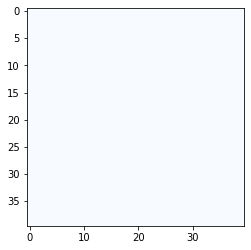

In [185]:
plot_grid_xy(0.7, rpyidx = np.array([4,9,1]))

Array([[34, 12,  5,  0,  3,  0],
       [34, 12,  5,  0,  3,  0],
       [33, 11,  5,  0,  3,  0],
       ...,
       [33, 11, 25,  0,  3,  0],
       [34, 12, 25,  0,  3,  0],
       [34, 12, 25,  0,  3,  0]], dtype=int32)

In [59]:
xyz2spherical_batch(batch[:, :3])

Array([[ 1.7320508 ,  0.9553166 , -2.3561945 ],
       [ 1.702958  ,  0.9431843 , -2.329885  ],
       [ 1.6749302 ,  0.93099034, -2.3021932 ],
       ...,
       [ 1.6749302 ,  0.93099034,  0.8393996 ],
       [ 1.702958  ,  0.9431843 ,  0.8117077 ],
       [ 1.7320508 ,  0.9553166 ,  0.7853981 ]], dtype=float32)

array([-1.        , -0.94871795, -0.8974359 , -0.84615385, -0.79487179,
       -0.74358974, -0.69230769, -0.64102564, -0.58974359, -0.53846154,
       -0.48717949, -0.43589744, -0.38461538, -0.33333333, -0.28205128,
       -0.23076923, -0.17948718, -0.12820513, -0.07692308, -0.02564103,
        0.02564103,  0.07692308,  0.12820513,  0.17948718,  0.23076923,
        0.28205128,  0.33333333,  0.38461538,  0.43589744,  0.48717949,
        0.53846154,  0.58974359,  0.64102564,  0.69230769,  0.74358974,
        0.79487179,  0.84615385,  0.8974359 ,  0.94871795,  1.        ])

In [40]:
batch

array([[ 0,  0, 20,  0,  3,  0],
       [ 1,  0, 20,  0,  3,  0],
       [ 2,  0, 20,  0,  3,  0],
       ...,
       [37, 39, 20,  0,  3,  0],
       [38, 39, 20,  0,  3,  0],
       [39, 39, 20,  0,  3,  0]])

In [13]:
jnp.prod(num_grids)

Array(27648000, dtype=int32)

In [11]:
jnp.pi/2 /20 * 1

0.07853981633974483